# Trabajo Práctico N°2: Modelo de predicción de precios de propiedades 

## Desafío 2. Modelo para el calculo del precio aproximado en USD de las  propiedades

Grupo Nª2
Alumnos:
* Alberto Paparelli
* André Song
* Marianela Riz
* Gloria Caravajal
* Franco Emanuel Rodriguez

Objetivos:
● Seleccionar los datos a modelar. Justificar esa selección.
● Entrenar al menos tres modelos de regresión lineal distintos sobre estos datos.
● Evaluar la performance de los modelos y comparar ventajas y desventajas de cada
uno.
● Determinar la importancia de las features incluidas en la predicción. Interpretar.

# Modelo a desarrollar

 Modelo para apartamentos usados empleando el mismo modelo de Palermo para Recoleta


# Importación de librerias

In [1]:
#importamos librerias para tratamiento de datos
import numpy as np
import pandas as pd
import re
import math as mat

#importamos librerias la visualizacion de datos
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import metrics
import statsmodels.api as sm
%matplotlib inline




## Cargue del Dataframe de Capital Federal

Hemos seleccionado este State_name porqué aunque con la limpieza se perdieron algunos datos, sigue teniendo una cantidad importante de datos.
Adicionalmente, estos datos ya traen consigo la información en los Place_name de los barrios de la Capital Federal, que puede ser una variable explicativa del precio del metro cuadrado de las propiedades.

In [2]:
filename = "../dataset/capital.csv"
data_original = pd.read_csv(filename, sep=',')
display(data_original.sample(n=2))
print(f"(Cantidad de Filas, Cantidad de columnas) -> {data_original.shape}")

,Unnamed: 0,numero,property_type,place_name,price_aprox_local_currency,price_aprox_usd,surface_total_in_m2,surface_covered_in_m2,price_usd_per_m2,price_per_m2,floor,rooms,expenses,piscina,Parrilla,Cochera,nuevo,description,title
11256,11256,11257,house,Caballito,7763580,440000,340,300,1294,1467,1,4,0,0,1,1,0,"Sobre Avenida Jose Maria Moreno, en una de las...",Casa en Venta
5541,5541,5542,apartment,Parque Centenario,2417297,137000,59,48,2322,2854,7,3,27000,0,0,0,0,3 AMBIENTES EN VENTA CON BALCÓN AL CONTRA FREN...,DEPARTAMENTO EN VENTA


(Cantidad de Filas, Cantidad de columnas) -> (16938, 19)


In [5]:

data=data_original[(data_original.property_type=='apartment') & (data_original.nuevo==0) &(data_original.price_aprox_usd<800000)
 & (data_original.surface_total_in_m2<500) & (data_original.surface_covered_in_m2<500) & (data_original.rooms>=1) 
 &(data_original.floor>=1) & (data_original.place_name=='Recoleta')]
display(data.sample(2))
data.shape

,Unnamed: 0,numero,property_type,place_name,price_aprox_local_currency,price_aprox_usd,surface_total_in_m2,surface_covered_in_m2,price_usd_per_m2,price_per_m2,floor,rooms,expenses,piscina,Parrilla,Cochera,nuevo,description,title
8727,8727,8728,apartment,Recoleta,2999565,170000,49,46,3469,3696,2,1,0,0,0,1,0,"Lindisimo monoambiente con balcón, cocina inte...",Av las Heras 2000
16453,16453,16454,apartment,Recoleta,11468925,650000,189,189,3439,3439,2,6,0,0,0,1,0,Muy buen Edificio Dubourg Cochera Fija al lado...,Rodriguez Peña y Av Alvear


(417, 19)

Vamos a eliminar las columnas que no vamos a emplear para desarrollar los modelos: Description y Title

In [6]:
data.drop([data.columns[0],"numero","description","price_aprox_local_currency","price_per_m2" ,"title", "property_type"], axis=1,inplace=True)
data.info() 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 417 entries, 290 to 16811
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   place_name             417 non-null    object
 1   price_aprox_usd        417 non-null    int64 
 2   surface_total_in_m2    417 non-null    int64 
 3   surface_covered_in_m2  417 non-null    int64 
 4   price_usd_per_m2       417 non-null    int64 
 5   floor                  417 non-null    int64 
 6   rooms                  417 non-null    int64 
 7   expenses               417 non-null    int64 
 8   piscina                417 non-null    int64 
 9   Parrilla               417 non-null    int64 
 10  Cochera                417 non-null    int64 
 11  nuevo                  417 non-null    int64 
dtypes: int64(11), object(1)
memory usage: 42.4+ KB


c:\Users\usuario\anaconda3\envs\dhdsblend2021\lib\site-packages\pandas\core\frame.py:4167: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


Creamos un grupo de variables númericas empleando. describe, tambien chequemos los valores minimos y máximos de las variables.

In [7]:
num=data.describe()
num

,price_aprox_usd,surface_total_in_m2,surface_covered_in_m2,price_usd_per_m2,floor,rooms,expenses,piscina,Parrilla,Cochera,nuevo
count,417.000000,417.000000,417.000000,417.000000,417.000000,417.000000,417.000000,417.000000,417.000000,417.000000,417.0
mean,341513.179856,113.937650,104.436451,3201.438849,2.887290,3.321343,18507.673861,0.074341,0.069544,0.340528,0.0
std,175148.769481,62.636013,57.901536,1650.957253,2.373584,1.492723,33425.794286,0.262639,0.254683,0.474456,0.0
min,57000.000000,10.000000,4.000000,1399.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.0
25%,210000.000000,65.000000,58.000000,2620.000000,2.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.0
50%,320000.000000,110.000000,101.000000,3026.000000,2.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.0
75%,450000.000000,151.000000,136.000000,3583.000000,4.000000,4.000000,27000.000000,0.000000,0.000000,1.000000,0.0
max,790000.000000,343.000000,303.000000,33000.000000,27.000000,8.000000,200000.000000,1.000000,1.000000,1.000000,0.0


Una vez tenemos una base limpia, sacamos una matriz de correlación para observar el comportamiento entre variables

In [8]:
data.corr()

,price_aprox_usd,surface_total_in_m2,surface_covered_in_m2,price_usd_per_m2,floor,rooms,expenses,piscina,Parrilla,Cochera,nuevo
price_aprox_usd,1.000000,0.869466,0.880555,0.042506,0.053171,0.723597,0.176943,0.042531,0.089462,0.417320,NaN
surface_total_in_m2,0.869466,1.000000,0.951690,-0.225380,0.062671,0.776248,0.204067,-0.039317,0.131824,0.253007,NaN
surface_covered_in_m2,0.880555,0.951690,1.000000,-0.089982,0.080887,0.806350,0.191736,-0.054303,0.025812,0.243872,NaN
price_usd_per_m2,0.042506,-0.225380,-0.089982,1.000000,-0.069708,-0.107046,0.107057,0.222649,-0.037839,0.177989,NaN
floor,0.053171,0.062671,0.080887,-0.069708,1.000000,0.069951,0.156015,-0.102208,-0.042674,0.051239,NaN
rooms,0.723597,0.776248,0.806350,-0.107046,0.069951,1.000000,0.075256,-0.091737,0.035922,0.252421,NaN
expenses,0.176943,0.204067,0.191736,0.107057,0.156015,0.075256,1.000000,0.013763,-0.052443,0.046550,NaN
piscina,0.042531,-0.039317,-0.054303,0.222649,-0.102208,-0.091737,0.013763,1.000000,0.210023,0.085722,NaN
Parrilla,0.089462,0.131824,0.025812,-0.037839,-0.042674,0.035922,-0.052443,0.210023,1.000000,0.082055,NaN
Cochera,0.417320,0.253007,0.243872,0.177989,0.051239,0.252421,0.046550,0.085722,0.082055,1.000000,NaN


Graficamos un mapa de calor para identificar cuales son las variables numericas que se relacionan más con el precio por metro cuadrado en dolares
Asi podemos ver que los datos que más se relacionan son: 

Text(0.5, 1.0, 'Heatmap')

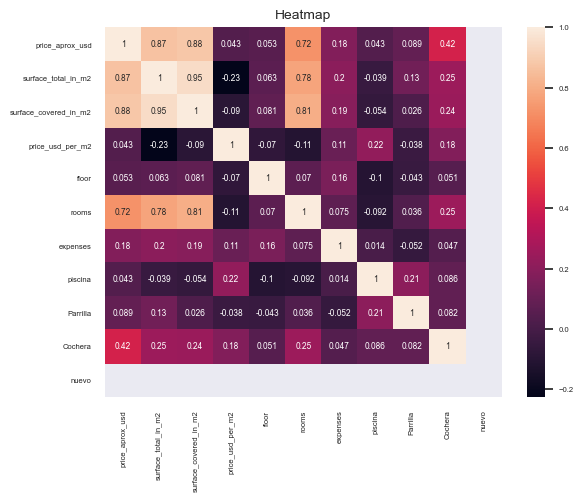

In [9]:
corr=data.corr()
sns.set(font_scale=0.5)
sns.heatmap(corr,annot=True)
plt.title("Heatmap",fontsize=10)

Ahora creamos un grupo de variables categoricas empleando. describe de tipo Object.

In [10]:
cat=data.describe(include=[object])  
cat

,place_name
count,417
unique,1
top,Recoleta
freq,417


Calculamos la media de las variables numericas tomando como base las variables **categoricas y las organizamos para poder hacer un analisis general
Lo que podemos ver en este analisis es que  ***por ejemplo que :xxx**

In [11]:
grpmean=data.groupby(list(cat.columns)).mean().sort_values(by=['place_name'])
grpmean[['price_aprox_usd', 'price_usd_per_m2','surface_total_in_m2', 'surface_covered_in_m2', 'floor', 'expenses', 'piscina', 'Parrilla', 'Cochera', 'nuevo']]

,price_aprox_usd,price_usd_per_m2,surface_total_in_m2,surface_covered_in_m2,floor,expenses,piscina,Parrilla,Cochera,nuevo
place_name,,,,,,,,,,
Recoleta,341513.179856,3201.438849,113.93765,104.436451,2.88729,18507.673861,0.074341,0.069544,0.340528,0.0


Tambien chequeamos cuantos datos tenemos en esa distribución

In [12]:
data.groupby(list(cat.columns)).count()

,price_aprox_usd,surface_total_in_m2,surface_covered_in_m2,price_usd_per_m2,floor,rooms,expenses,piscina,Parrilla,Cochera,nuevo
place_name,,,,,,,,,,,
Recoleta,417,417,417,417,417,417,417,417,417,417,417


In [13]:
num.columns

Index(['price_aprox_usd', 'surface_total_in_m2', 'surface_covered_in_m2',
       'price_usd_per_m2', 'floor', 'rooms', 'expenses', 'piscina', 'Parrilla',
       'Cochera', 'nuevo'],
      dtype='object')

Generamos variables dummies 

In [14]:
datadum=pd.get_dummies(data)
datadum.columns

Index(['price_aprox_usd', 'surface_total_in_m2', 'surface_covered_in_m2',
       'price_usd_per_m2', 'floor', 'rooms', 'expenses', 'piscina', 'Parrilla',
       'Cochera', 'nuevo', 'place_name_Recoleta'],
      dtype='object')

In [15]:
datadum.head()

,price_aprox_usd,surface_total_in_m2,surface_covered_in_m2,price_usd_per_m2,floor,rooms,expenses,piscina,Parrilla,Cochera,nuevo,place_name_Recoleta
290,150000,100,92,1500,9,3,0,0,0,0,0,1
442,70000,40,35,1750,6,1,0,0,0,0,0,1
564,150000,80,65,1875,1,4,45000,0,0,0,0,1
637,498000,250,243,1992,2,5,0,0,0,0,0,1
638,498000,250,243,1992,2,5,0,0,0,0,0,1


# Modelo 3

Para el tercer modelo emplearemos la base de datos de los apartamentos usados de Recoleta y emplearemos las features surface_total_in_m2', 'surface_covered_in_m2', 'rooms', 'Cochera' ,'floor', 'expenses', 'piscina', 'Parrilla

In [16]:
#featcol=['surface_total_in_m2', 'surface_covered_in_m2', 'rooms', 'Cochera']

featcol=['surface_total_in_m2', 'surface_covered_in_m2', 'rooms', 'Cochera' ,'floor', 'expenses', 'piscina', 'Parrilla']
#featcol=['surface_total_in_m2', 'surface_covered_in_m2', 'Cochera','piscina']

X=datadum[featcol]
y=datadum[['price_aprox_usd']]

Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, random_state=123)



In [17]:
#featcol=['surface_total_in_m2', 'surface_covered_in_m2', 'rooms', 'Cochera']
featcol=['surface_total_in_m2', 'surface_covered_in_m2', 'rooms', 'Cochera' ,'floor', 'expenses', 'piscina', 'Parrilla']
#featcol=['surface_total_in_m2', 'surface_covered_in_m2', 'Cochera','piscina']

X=Xtrain[featcol]
y=ytrain

# Tenemos que agregar explícitamente a una constante:
X = sm.add_constant(X)

model_1= sm.OLS(y, X).fit()

print(model_1.summary())

                            OLS Regression Results                            
Dep. Variable:        price_aprox_usd   R-squared:                       0.822
Model:                            OLS   Adj. R-squared:                  0.817
Method:                 Least Squares   F-statistic:                     174.6
Date:                Thu, 03 Nov 2022   Prob (F-statistic):          1.16e-108
Time:                        10:42:03   Log-Likelihood:                -3947.9
No. Observations:                 312   AIC:                             7914.
Df Residuals:                     303   BIC:                             7947.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                  4.867e+

In [18]:
featcol=['surface_total_in_m2', 'surface_covered_in_m2', 'rooms', 'Cochera' ,'floor', 'expenses', 'piscina', 'Parrilla']

Xtrain_sklearn = Xtrain[featcol]

model_1 = LinearRegression(fit_intercept=True)

model_1.fit(Xtrain_sklearn, ytrain)

print(model_1.coef_)

print(model_1.intercept_)

[[ 9.75150762e+02  1.59711668e+03 -3.05510139e+03  7.32624173e+04
  -1.48781631e+03  1.28197362e-01  3.14315337e+04  1.32022700e+04]]
[48674.27658341]


In [19]:
print("R2: ", model_1.score(Xtrain_sklearn, ytrain))

n = len(ytrain)
p = 5
ypred_train = model_1.predict(Xtrain_sklearn)
r2 = metrics.r2_score(ytrain, ypred_train)
r2_ajustado = 1 - (1 - r2)*((n-1)/(n - p - 1))

print("R2: ", metrics.r2_score(ytrain, ypred_train))
print("R2 ajustado: ", r2_ajustado)
print('Mean Absolute Error:', metrics.mean_absolute_error(ytrain, ypred_train))
print('Mean Squared Error:', metrics.mean_squared_error(ytrain, ypred_train))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(ytrain, ypred_train)))

R2:  0.8217260233393906
R2:  0.8217260233393906
R2 ajustado:  0.8188130498645441
Mean Absolute Error: 55918.58512836799
Mean Squared Error: 5730826994.334349
Root Mean Squared Error: 75702.2258215328


In [20]:
Xtest_sklearn = Xtest[featcol]

print("R2: ", model_1.score(Xtest_sklearn, ytest))

n = len(ytest)
p = 5
ypred_test = model_1.predict(Xtest_sklearn)
r2 = metrics.r2_score(ytest, ypred_test)
r2_ajustado = 1 - (1 - r2)*((n-1)/(n - p - 1))

print("R2: ", metrics.r2_score(ytest, ypred_test))
print("R2 ajustado: ", r2_ajustado)
print('Mean Absolute Error:', metrics.mean_absolute_error(ytest, ypred_test))
print('Mean Squared Error:', metrics.mean_squared_error(ytest, ypred_test))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(ytest, ypred_test)))

R2:  0.8552004826236769
R2:  0.8552004826236769
R2 ajustado:  0.8478873756854788
Mean Absolute Error: 46405.25902057378
Mean Squared Error: 3708374350.574744
Root Mean Squared Error: 60896.42313448914
